# Training Your Custom Magic Wand Model

It is now time for you to train your own custom magic wand model using your Custom Dataset!

##Setup

### Import Packages and Set Constants

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import files
from IPython.display import Image, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import PIL
import math
import glob
import json
import os
!apt-get update && apt-get -qq install xxd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [66.7 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Package

In [2]:
# Define filenames and set up directory structure
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand")
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand.tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand.cc")

DATASET_DIR =  'dataset'
if not os.path.exists(DATASET_DIR):
  os.mkdir(DATASET_DIR)
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")
!rm -rf sample_data

CHKPT_DIR =  'checkpoints'
if not os.path.exists(CHKPT_DIR):
  os.mkdir(CHKPT_DIR)

# Train Split
TEST_PERCENTAGE = 10
VALIDATION_PERCENTAGE = 10
TRAIN_PERCENTAGE = 100 - (TEST_PERCENTAGE + VALIDATION_PERCENTAGE)

### Load Your Custom Dataset
Now you'll need to upload all of your custom gesture files that you created using the Magic Wand tool (aka the ```*.json``` files). **Note: you can select multiple files and upload them all at once!**

If you are having trouble uploading files because your internet bandwidth is too slow feel free to uncomment the lines below to instead use Pete's digits dataset.

In [ ]:
# Upload your files
os.chdir("/content/dataset")
uploaded = files.upload()
os.chdir("/content")

In [5]:
# Or use Pete's Digits Dataset
!curl -L https://github.com/petewarden/magic_wand_digit_data/archive/8170591863f9addca27b1a963263f7c7bed33f41.zip -o magic_wand_digit_data.zip
!unzip magic_wand_digit_data.zip
!rm -rf magic_wand_digit_data.zip
!mv magic_wand_digit_data-*/* dataset
!rm -rf magic_wand_digit_data-*

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  238k    0  238k    0     0   394k      0 --:--:-- --:--:-- --:--:-- 1569k
Archive:  magic_wand_digit_data.zip
8170591863f9addca27b1a963263f7c7bed33f41
   creating: magic_wand_digit_data-8170591863f9addca27b1a963263f7c7bed33f41/
  inflating: magic_wand_digit_data-8170591863f9addca27b1a963263f7c7bed33f41/LICENSE  
  inflating: magic_wand_digit_data-8170591863f9addca27b1a963263f7c7bed33f41/petewarden_0.json  
  inflating: magic_wand_digit_data-8170591863f9addca27b1a963263f7c7bed33f41/petewarden_1.json  
  inflating: magic_wand_digit_data-8170591863f9addca27b1a963263f7c7bed33f41/petewarden_2.json  
  inflating: magic_wand_digit_data-8170591863f9addca27b1a963263f7c7bed33f41/petewarden_3.json  
  inflating: magic_wand_digit_data-8170591863f9addca27b1a963

**Update the variable below with the number of labeled gestures in your dataset**
Note: Use the number of unique gestures/labels and *not* the number of samples in your dataset.

In [6]:
NUM_GESTURES = 10 # UPDATE THIS WITH THE NUMBER OF UNIQUE GESTURES IN YOUR DATASET #

Next we'll parse the JSON files into a python object which we can more easily work with.

In [7]:
dataset_jsons = DATASET_DIR + "/*.json"
strokes = []
for filename in glob.glob(dataset_jsons):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

If you'd like to visualize any of your gestures you can use the helper function below!

In [8]:
# Helper function to visualize the data
def plot_stroke(stroke):
  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

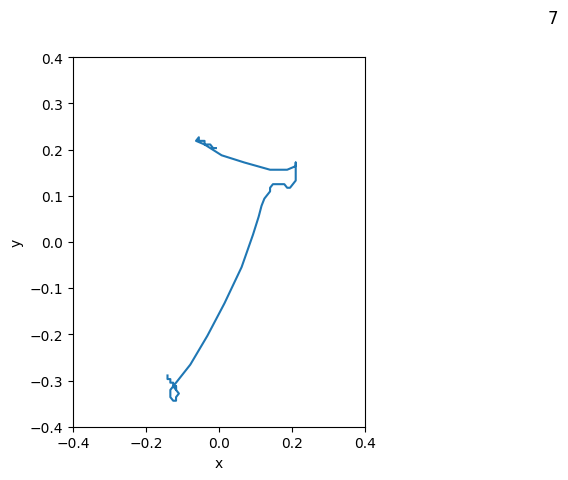

In [9]:
# Display a stroke from the strokes python variable
plot_stroke(strokes[0])

### Preprocess your Dataset
Next we'll preprocess the dataset to prepare it for training. By preprocessing the data in bulk before training the whole training process will execute much faster. To do so, we'll convert the strokes into rastered images using the helper functions below. This is the process used in real-time in the Arduino code to convert a gesture into an image that the CNN we are going to train can then process.

Once we have converted the dataset to rasterized images we will generate a ```Keras``` dataset for use in training.

In [10]:
FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

In [11]:
X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))
  return labels

Take the dataset and shuffle it into the Training/Validation/Test splits

In [12]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_count = math.floor((len(shuffled_strokes) * TEST_PERCENTAGE) / 100)
validation_count = math.floor((len(shuffled_strokes) * VALIDATION_PERCENTAGE) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

labels_test  = save_strokes_as_images(test_strokes, TEST_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 10)
labels_val   = save_strokes_as_images(validation_strokes, VAL_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 0)
labels_train = save_strokes_as_images(train_strokes, TRAIN_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 10)

Also get the alphanumeric ordering of the labels as the Nueral Network will output its result in this order for the predicted class. **Make a note of this ordering as you will need to enter the labels in order in the Arduino code!**

In [13]:
labels = sorted(labels_test.union(labels_val).union(labels_train))
# get the conversion from label string to int
labelToInt = {}
currInt = 0
for label in labels:
  labelToInt[label] = currInt
  currInt = currInt + 1
intToLabel = {v: k for k, v in labelToInt.items()}
print(intToLabel)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}


If you'd like to visualize the difference between a stroke and its rasterized output image, run the cell below!

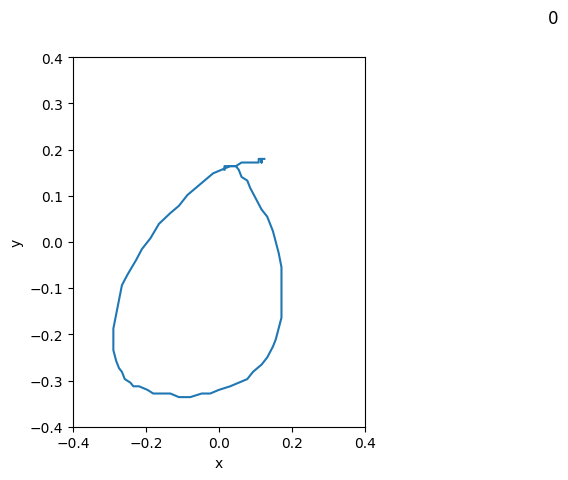

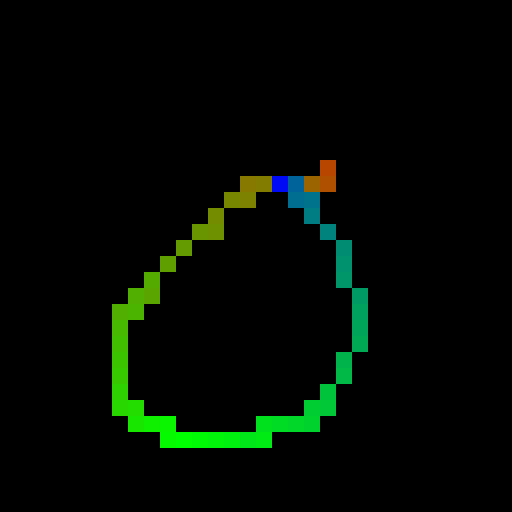

In [14]:
plot_stroke(strokes[0])
raster = rasterize_stroke(strokes[0]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

Finally, we'll generate a dataset in ```Keras```.

In [15]:
validation_ds = image_dataset_from_directory(
    directory=VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 100 files belonging to 10 classes.
Found 8800 files belonging to 10 classes.


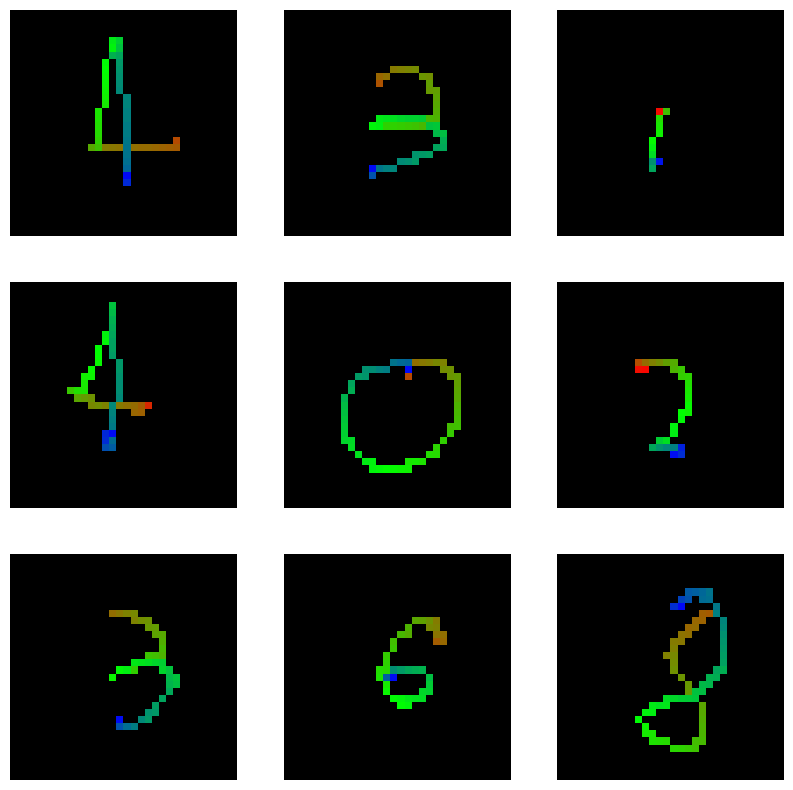

In [16]:
# Plot 9 of our final dataset items
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

## Define your Model

Next we will define and visualize the CNN model that we will use for the magic wand!

In [17]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_GESTURES)

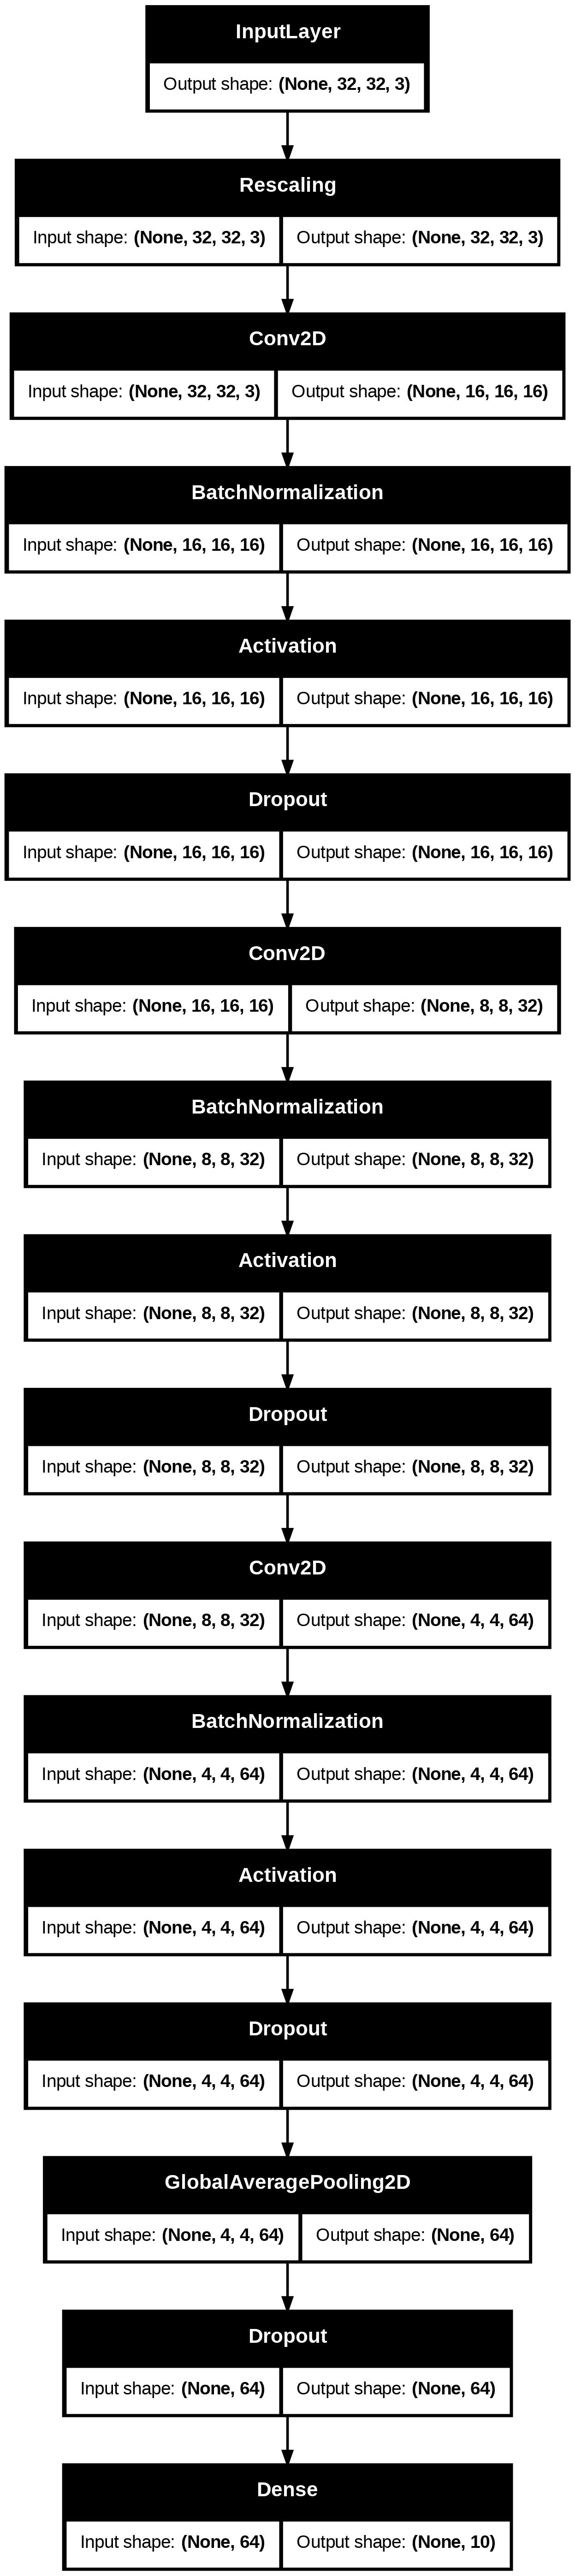

In [18]:
# View the model layers as a diagram
keras.utils.plot_model(model, show_shapes=True)

## Train your Model

Now that we have a preprocessed dataset and a model its time to train that model with that dataset!

In [19]:
# How many epochs to train for, we have found ~30 to be a good starting point
EPOCHS = 30

# Callback to save model checkpoints for future inspection or training
checkpointFileLoc = CHKPT_DIR + "/save_at_{epoch:02d}.h5"
modelCheckpointCallback = keras.callbacks.ModelCheckpoint(checkpointFileLoc)

# Compile the model!
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Run training
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds,
                    callbacks=[modelCheckpointCallback])

Epoch 1/30
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1275 - loss: 0.4717

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1276 - loss: 0.4711 - val_accuracy: 0.1000 - val_loss: 0.3651
Epoch 2/30
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2011 - loss: 0.3198

275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.2013 - loss: 0.3198 - val_accuracy: 0.4600 - val_loss: 0.2917
Epoch 3/30
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2665 - loss: 0.3016

275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.2667 - loss: 0.3015 - val_accuracy: 0.8100 - val_loss: 0.2382
Epoch 4/30
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3337 - loss: 0.2844

275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.3339 - loss: 0.2843 - val_accuracy: 0.7400 - val_loss: 0.2141
Epoch 5/30
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3969 - loss: 0.2663

275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.3970 - loss: 0.2663 - val_accuracy: 0.8700 - val_loss: 0.1950
Epoch 6/30
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4395 - loss: 0.2492

275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.4397 - loss: 0.2492 - val_accuracy: 0.9000 - val_loss: 0.1766
Epoch 7/30
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4971 - loss: 0.2349

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4972 - loss: 0.2348 - val_accuracy: 0.7400 - val_loss: 0.1732
Epoch 8/30
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5372 - loss: 0.2224

275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5373 - loss: 0.2224 - val_accuracy: 0.9500 - val_loss: 0.1422
Epoch 9/30
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5774 - loss: 0.2112

275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5776 - loss: 0.2112 - val_accuracy: 0.9800 - val_loss: 0.1296
Epoch 10/30
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6126 - loss: 0.1997

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6127 - loss: 0.1997 - val_accuracy: 0.9500 - val_loss: 0.1210
Epoch 11/30
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6261 - loss: 0.1946

275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6261 - loss: 0.1946 - val_accuracy: 0.9100 - val_loss: 0.1144
Epoch 12/30
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6533 - loss: 0.1852

275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6534 - loss: 0.1852 - val_accuracy: 0.9700 - val_loss: 0.1047
Epoch 13/30
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6880 - loss: 0.1754

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6880 - loss: 0.1755 - val_accuracy: 0.9700 - val_loss: 0.0929
Epoch 14/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6846 - loss: 0.1761

275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6846 - loss: 0.1761 - val_accuracy: 0.9600 - val_loss: 0.0922
Epoch 15/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7034 - loss: 0.1678

275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7033 - loss: 0.1678 - val_accuracy: 0.9900 - val_loss: 0.0855
Epoch 16/30
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7093 - loss: 0.1659

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7094 - loss: 0.1659 - val_accuracy: 0.9800 - val_loss: 0.0777
Epoch 17/30
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7244 - loss: 0.1585

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7244 - loss: 0.1585 - val_accuracy: 0.6700 - val_loss: 0.1803
Epoch 18/30
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7344 - loss: 0.1583

275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7344 - loss: 0.1583 - val_accuracy: 0.9700 - val_loss: 0.0815
Epoch 19/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7536 - loss: 0.1517

275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7536 - loss: 0.1517 - val_accuracy: 0.9300 - val_loss: 0.0804
Epoch 20/30
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7493 - loss: 0.1508

275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7493 - loss: 0.1507 - val_accuracy: 0.9900 - val_loss: 0.0613
Epoch 21/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7599 - loss: 0.1479

275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7598 - loss: 0.1479 - val_accuracy: 0.9900 - val_loss: 0.0626
Epoch 22/30
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7668 - loss: 0.1465

275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7667 - loss: 0.1465 - val_accuracy: 0.9600 - val_loss: 0.0587
Epoch 23/30
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7732 - loss: 0.1432

275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7732 - loss: 0.1432 - val_accuracy: 0.9900 - val_loss: 0.0572
Epoch 24/30
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7769 - loss: 0.1398

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7770 - loss: 0.1398 - val_accuracy: 1.0000 - val_loss: 0.0570
Epoch 25/30
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7833 - loss: 0.1366

275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7833 - loss: 0.1366 - val_accuracy: 0.9700 - val_loss: 0.0573
Epoch 26/30
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7744 - loss: 0.1378

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7746 - loss: 0.1378 - val_accuracy: 0.9800 - val_loss: 0.0520
Epoch 27/30
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7881 - loss: 0.1371

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7881 - loss: 0.1371 - val_accuracy: 0.9800 - val_loss: 0.0485
Epoch 28/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7753 - loss: 0.1381

275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7753 - loss: 0.1381 - val_accuracy: 1.0000 - val_loss: 0.0510
Epoch 29/30
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7931 - loss: 0.1332

275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7931 - loss: 0.1332 - val_accuracy: 0.9900 - val_loss: 0.0499
Epoch 30/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8061 - loss: 0.1311

275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8060 - loss: 0.1311 - val_accuracy: 0.9700 - val_loss: 0.0435


In [21]:
# save the model file
model.save('my_model.keras')

## Test your TensorFlow Model

Lets now test out the TF model on the test dataset. We'll print out any gesture we get wrong as well as the percentage of known gestures correct as well as the number of gestures that were marked as unknown.

Testing Gesture:  8  with datasize:  88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━

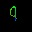

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━

In [22]:
SCORE_THRESHOLD = 0.75 # Confidence threshold to discard an image as "unknown"

def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob(TEST_DIR + "/*"):
  label = label_dir.replace(TEST_DIR + "/", "")
  print("Testing Gesture: ",label," with datasize: ",len(glob.glob(label_dir + "/*.png")))
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_image(model, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
      continue
    if index == labelToInt[label]:
      correct_count += 1
    else:
      wrong_count += 1
      print(label,index,score)
      print("[%s] expected, [%s] found with score [%f]" % (label, intToLabel[index], score))
      display(Image(filename=filename))

if correct_count + wrong_count == 0:
  print("All images marked as unknown!")
else:
  correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
  print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

If you'd like to manually evaluate particular images you can uncomment, update, and run the below cell and select an image from the test folder.

In [ ]:
# TEST_IMAGE = # UPDATE ME e.g., "test/0/1.png"
# index, score = predict_image(model, TEST_IMAGE)
# print(index, score) # prints the guessed index and the confidence

## Generate a TensorFlow Lite Model

Convert the frozen graph into a TensorFlow Lite model, which is fully quantized for use with embedded devices. The following cell will also print the model size.

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras.models.load_model('my_model.keras'))
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob(TEST_DIR + "/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmp22taigfz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132849964360592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847276838352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847276835664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847276836048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847276842192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847276837776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847276837008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847273533392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847273534160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847273531472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847273533008:

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


31640

Compare the sizes of the Tensorflow, TensorFlow Lite and Quantized TensorFlow Lite models.

In [25]:
def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


FileNotFoundError: [Errno 2] No such file or directory: 'models/magic_wand'

In [27]:
# ... previous code ...
def get_dir_size(dir):
  size = 0
  # Check if the path is a directory before scanning it
  if os.path.isdir(dir):  # Check if it's a directory
    for f in os.scandir(dir):
      if f.is_file():
        size += f.stat().st_size
      elif f.is_dir():
        size += get_dir_size(f.path)
  # If it's a file, just get the file size
  elif os.path.isfile(dir):
    size = os.path.getsize(dir)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME) # Now correctly handles files as well
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

Size                            
Model                                                               
TensorFlow                       0 bytes                            
TensorFlow Lite            100880 bytes   (reduced by -100880 bytes)
TensorFlow Lite Quantized    31640 bytes    (reduced by 69240 bytes)

## Test your TensorFlow Lite Models

Lets now test out the TFLite models (quantized and unquantized) on the test dataset. We'll print out any gesture we get wrong as well as the percentage of known gestures correct as well as the number of gestures that were marked as unknown.

In [28]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [29]:
def run_tflite_test(model_file):
  correct_count = 0
  wrong_count = 0
  discarded_count = 0
  for label_dir in glob.glob(TEST_DIR + "/*"):
    label = label_dir.replace(TEST_DIR + "/", "")
    print("Testing Gesture: ",label," with datasize: ",len(glob.glob(label_dir + "/*.png")))
    for filename in glob.glob(label_dir + "/*.png"):
      index, score = predict_tflite(model_file, filename)
      if score < 0.75:
        discarded_count += 1
        continue
      if index == labelToInt[label]:
        correct_count += 1
      else:
        wrong_count += 1
        print("[%s] expected, [%s] found with score [%f]" % (label, intToLabel[index], score))
        display(Image(filename=filename))

  correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

  print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

First test the float model.

Testing Gesture:  8  with datasize:  88
Testing Gesture:  2  with datasize:  143
Testing Gesture:  1  with datasize:  99
Testing Gesture:  4  with datasize:  77
Testing Gesture:  7  with datasize:  143
Testing Gesture:  0  with datasize:  143
Testing Gesture:  9  with datasize:  110
[9] expected, [1] found with score [0.760371]


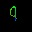

Testing Gesture:  3  with datasize:  132
Testing Gesture:  5  with datasize:  99
Testing Gesture:  6  with datasize:  66
99.9% correct (N=945, 155 unknown)


In [30]:
run_tflite_test(model_no_quant_tflite)

Then test the quantized model

Testing Gesture:  8  with datasize:  88
Testing Gesture:  2  with datasize:  143
Testing Gesture:  1  with datasize:  99
Testing Gesture:  4  with datasize:  77
Testing Gesture:  7  with datasize:  143
Testing Gesture:  0  with datasize:  143
Testing Gesture:  9  with datasize:  110
[9] expected, [1] found with score [0.773438]


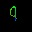

Testing Gesture:  3  with datasize:  132
Testing Gesture:  5  with datasize:  99
Testing Gesture:  6  with datasize:  66
99.9% correct (N=960, 140 unknown)


In [31]:
run_tflite_test(model_tflite)

If you'd like to manually evaluate particular images you can uncomment, update, and run the below cell and select an image from the test folder.

In [ ]:
# TEST_IMAGE = # UPDATE ME e.g., "test/0/1.png"
# index, score = predict_tflite(model_no_quant_tflite, TEST_IMAGE)
# print("Float model result:")
# print(index, score) # prints the guessed index and the confidence
# index, score = predict_tflite(model_tflite, TEST_IMAGE)
# print("Quantized model result:")
# print(index, score) # prints the guessed index and the confidence

## Generate a TensorFlow Lite for Microcontrollers Model
To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we simply need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [32]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

That's it! You've successfully converted your TensorFlow Lite model into a TensorFlow Lite for Microcontrollers model! Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE!

In [33]:
# Print the C source file
!cat {TFL_CC_MODEL_FILENAME}
# !tail {TFL_CC_MODEL_FILENAME} # run this command to just see the end of the file (aka the size)

unsigned char g_magic_wand_model_data[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x94, 0x00, 0x00, 0x00, 0x14, 0x01, 0x00, 0x00, 0xb4, 0x62, 0x00, 0x00,
  0xc4, 0x62, 0x00, 0x00, 0x04, 0x7b, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x6c, 0xff, 0xff, 0xff, 0x0f, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x6f, 0x75, 0x74, 0x70,
  0x75, 0x74, 0x5f, 0x30, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 

To download your model for use at a later date:

1. On the left of the UI click on the folder icon
2. Click on the three dots to the right of the ```.cc``` file you just generated and select "download." The file can be found at ```models/{TFL_CC_MODEL_FILENAME}``` which by default is ```models/magic_wand.cc```

Next we'll deploy that model using the Arduino IDE.